In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import h5py
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import torch 
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from glob import glob
import torch
from torch.autograd import Variable
import time
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from utils import progress_bar
from sklearn.decomposition import PCA
import pickle
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = 7, 5
matplotlib.rcParams['lines.linewidth'] = 1

In [2]:
qcd = np.load("/bigdata/shared/IML/qcd.npy",encoding='bytes')

In [3]:
print(qcd.dtype.names)
print(qcd.shape)

('genjet_sd_m', 'recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m', 'recojet_sd_pt', 'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m', 'n_constituents', 'constituents_pt', 'constituents_eta', 'constituents_phi', 'constituents_charge', 'constituents_dxy', 'constituents_dz', 'constituents_Eem', 'constituents_Ehad')
(1042167,)


### Sneak peek at the data

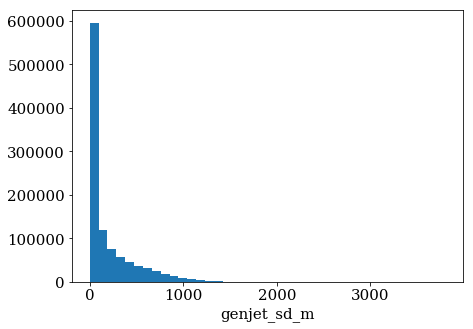

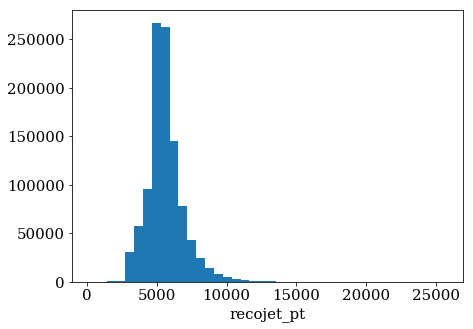

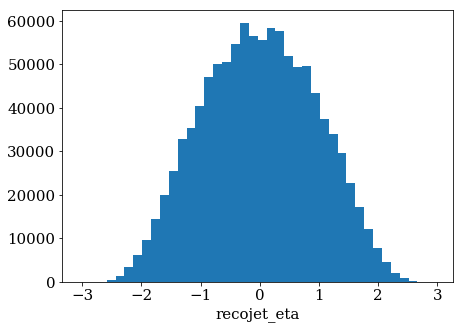

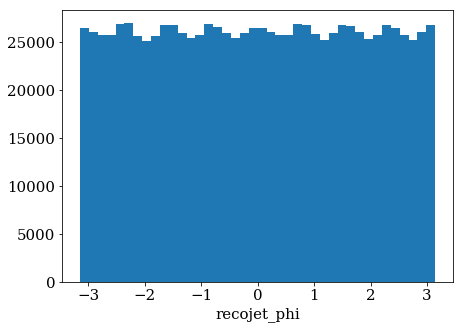

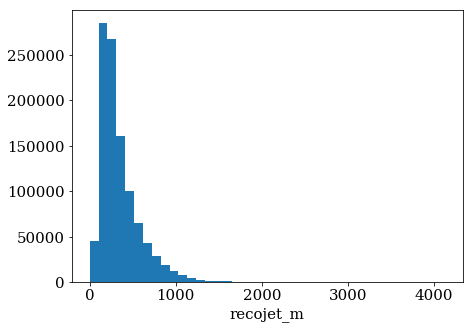

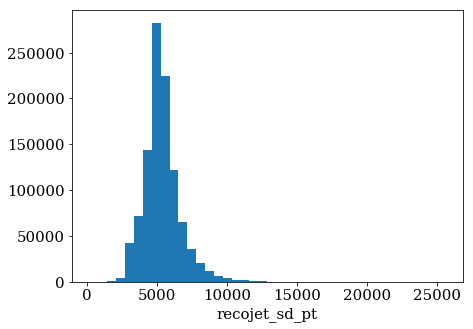

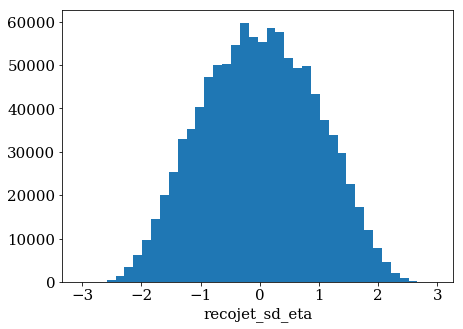

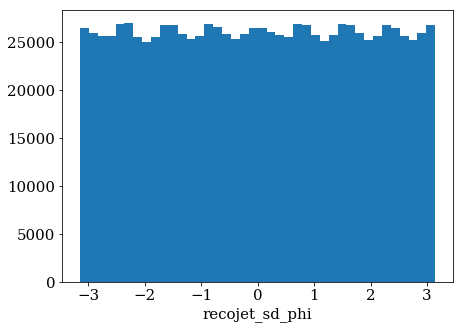

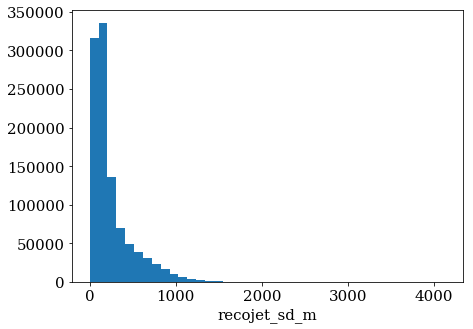

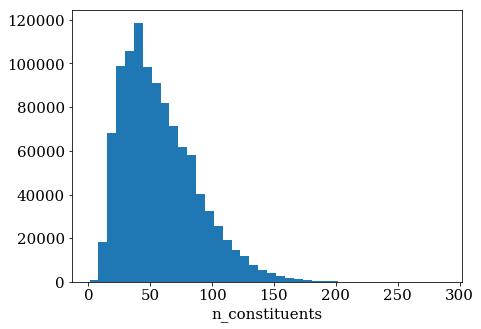

In [4]:
for key in qcd.dtype.names:
    if 'constituents_' not in key:
        if not np.isfinite(qcd[key]).all():
            print ("{} has non-numerical values".format(key))
        plt.figure()
        plt.hist(qcd[key],bins=40)
        plt.xlabel(key)

### Check genjet_sd_m with jet pt between 5 and 7 TeV

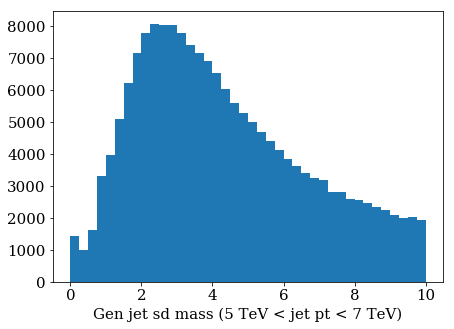

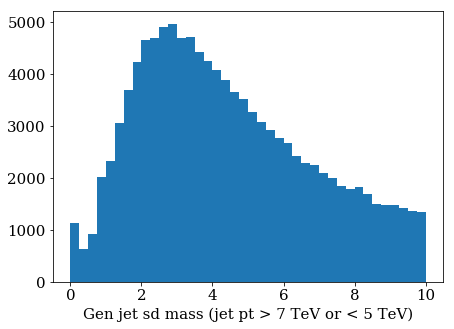

In [5]:
plt.figure()
x = np.asarray(qcd['genjet_sd_m'])
pt = np.asarray(qcd['recojet_pt'])
masked = (pt > 5000) & (pt < 7000)
masked.reshape(-1,1)
plt.hist(x[masked],bins=40, range=(0,10))
plt.xlabel('Gen jet sd mass (5 TeV < jet pt < 7 TeV)')
plt.figure()
masked2 = (pt < 5000) | (pt > 7000)
masked2.reshape(-1,1)
plt.hist(x[masked2],bins=40,range=(0,10))
plt.xlabel('Gen jet sd mass (jet pt > 7 TeV or < 5 TeV)')

### Create a separate dataset for constituents

In [6]:
constituents = np.zeros((qcd.shape[0],300,8))
for i in range(qcd.shape[0]):
    constituents[i,:qcd['n_constituents'][i],0] = qcd['constituents_pt'][i]
    constituents[i,:qcd['n_constituents'][i],1] = qcd['constituents_eta'][i]
    constituents[i,:qcd['n_constituents'][i],2] = qcd['constituents_phi'][i]
    constituents[i,:qcd['n_constituents'][i],3] = qcd['constituents_charge'][i]
    constituents[i,:qcd['n_constituents'][i],4] = qcd['constituents_dxy'][i]
    constituents[i,:qcd['n_constituents'][i],5] = qcd['constituents_dz'][i]
    constituents[i,:qcd['n_constituents'][i],6] = qcd['constituents_Eem'][i]
    constituents[i,:qcd['n_constituents'][i],7] = qcd['constituents_Ehad'][i]
print(constituents.shape)

(1042167, 300, 8)


## And a separate dataset for jet info

In [7]:
jets = np.swapaxes(np.vstack((qcd['recojet_pt'], qcd['recojet_eta'], qcd['recojet_phi'], qcd['recojet_m'],
                 qcd['recojet_sd_pt'], qcd['recojet_sd_eta'], qcd['recojet_sd_phi'],
                 qcd['recojet_sd_m'], qcd['n_constituents'])), 1,0)
constituents_name = ['constituents_pt', 'constituents_eta', 'constituents_phi', 'constituents_charge', 
                     'constituents_dxy', 'constituents_dz', 'constituents_Eem', 'constituents_Ehad']
jets_name = ['recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m', 'recojet_sd_pt', 
             'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m', 'n_constituents']

### Standardize dataset (separately for each feature to have more control)

In [13]:
scalers = dict((key,0) for key in qcd.dtype.names) 
for key in qcd.dtype.names:
    scalers[key] = StandardScaler()
    if 'constituents_' not in key:
        scalers[key].fit(qcd[key].reshape((qcd[key].shape[0],1)))
    else:
        to_fit = constituents[:,:,constituents_name.index(key)].reshape((1,-1))
        masked_to_fit = to_fit[np.logical_and(to_fit, to_fit != 0, to_fit > -999.)].reshape(-1,1)
        scalers[key].fit(masked_to_fit)


In [14]:
scalers['jets'] = StandardScaler()
scalers['jets'].fit(jets)
scalers['jets'].mean_.shape

(9,)

In [15]:
scaled_jets = scalers['jets'].transform(jets)

[[-0.45261003]
 [ 1.03705417]]


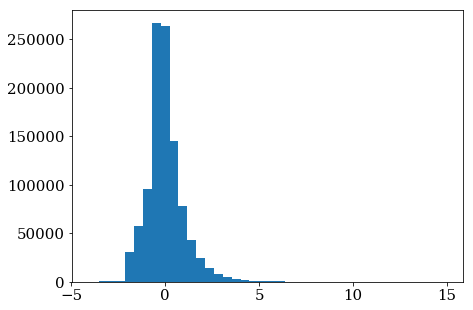

In [16]:
#print(scalers.keys())
plt.hist(scaled_jets[:,0], bins=40)
sample_jets = np.asarray([5000,7000]).reshape(-1,1)
scaled_sample_jet = scalers['recojet_pt'].transform(sample_jets)
print(scaled_sample_jet)

### Sort the constituents by pT and standardize

In [17]:
length = constituents.shape[0]
sorted_pt_constituents = np.zeros(shape=constituents.shape)
transformed = dict((key,0) for key in constituents_name) 
for evt in range(length):
    if (evt % 50000 == 0): print("{}/{}".format(evt,length))
    sorted_pt_constituents[evt] = np.sort((constituents[evt]),axis=0)[::-1]
    for key in constituents_name:
        transformed[key] = scalers[key].transform(sorted_pt_constituents[evt][:,constituents_name.index(key)].reshape(-1,1))
    sorted_pt_constituents[evt] = np.concatenate([transformed[key] for key in constituents_name], axis = 1)
print(sorted_pt_constituents.shape)

0/1042167
50000/1042167
100000/1042167
150000/1042167
200000/1042167
250000/1042167
300000/1042167
350000/1042167
400000/1042167
450000/1042167
500000/1042167
550000/1042167
600000/1042167
650000/1042167
700000/1042167
750000/1042167
800000/1042167
850000/1042167
900000/1042167
950000/1042167
1000000/1042167
(1042167, 300, 8)


### PCA because why not

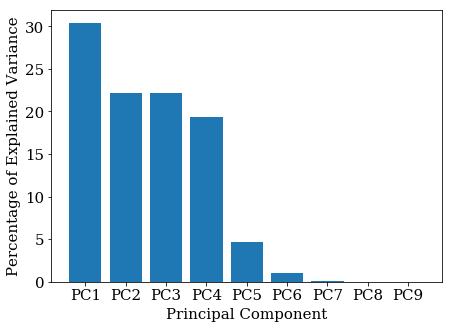

(1042167, 9)


In [22]:
pca = PCA()
pca.fit(scaled_jets)
pca_data = pca.transform(scaled_jets)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
plt.bar(range(1,len(per_var)+1), per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()

print(pca_data.shape)

In [25]:
pca_data[:,0]

array([ 3.20410685, -1.05125947, -0.48161875, ...,  1.5655103 ,
       -0.17884063,  0.06771102])

### Save the preprocessed datasets to file

In [27]:
with h5py.File("/bigdata/shared/IML/preprocessed_qcd.h5","w") as out:
    out['Constituents'] = sorted_pt_constituents
    out['Jets'] = scaled_jets
    out['Targets'] = qcd['genjet_sd_m']
    out['PCA'] = pca_data[:,:6]

pickle.dump( scalers, open( "scalers.p", "wb" ) )
pickle.dump(pca, open("pca.p","wb"))

---
<a id='loading_dataset'></a>

# Preprocess the test set

In [4]:
qcd_test = np.load("/bigdata/shared/IML/qcd_test.npy",encoding='bytes')
constituents_test = np.zeros((qcd_test.shape[0],300,8))
for i in range(qcd_test.shape[0]):
    n_consti = min(qcd_test['n_constituents'][i],300)
    constituents_test[i,:n_consti,0] = qcd_test['constituents_pt'][i][:n_consti]
    constituents_test[i,:n_consti,1] = qcd_test['constituents_eta'][i][:n_consti]
    constituents_test[i,:n_consti,2] = qcd_test['constituents_phi'][i][:n_consti]
    constituents_test[i,:n_consti,3] = qcd_test['constituents_charge'][i][:n_consti]
    constituents_test[i,:n_consti,4] = qcd_test['constituents_dxy'][i][:n_consti]
    constituents_test[i,:n_consti,5] = qcd_test['constituents_dz'][i][:n_consti]
    constituents_test[i,:n_consti,6] = qcd_test['constituents_Eem'][i][:n_consti]
    constituents_test[i,:n_consti,7] = qcd_test['constituents_Ehad'][i][:n_consti]
print(constituents_test.shape)
jets_test = np.swapaxes(np.vstack((qcd_test['recojet_pt'], qcd_test['recojet_eta'], qcd_test['recojet_phi'], 
                qcd_test['recojet_m'], qcd_test['recojet_sd_pt'], qcd_test['recojet_sd_eta'], 
                qcd_test['recojet_sd_phi'], qcd_test['recojet_sd_m'], qcd_test['n_constituents'])), 1,0)
constituents_name = ['constituents_pt', 'constituents_eta', 'constituents_phi', 'constituents_charge', 
                     'constituents_dxy', 'constituents_dz', 'constituents_Eem', 'constituents_Ehad']
jets_name = ['recojet_pt', 'recojet_eta', 'recojet_phi', 'recojet_m', 'recojet_sd_pt', 
             'recojet_sd_eta', 'recojet_sd_phi', 'recojet_sd_m', 'n_constituents']
scalers = pickle.load(open( "scalers.p", "rb" ))
pca = pickle.load(open("pca.p","rb"))
scaled_jets_test = scalers['jets'].transform(jets_test)
pca_data_test = pca.transform(scaled_jets_test)

length_test = constituents_test.shape[0]
sorted_pt_constituents_test = np.zeros(shape=constituents_test.shape)
transformed = dict((key,0) for key in constituents_name) 
for evt in range(length_test):
    if (evt % 50000 == 0): print("{}/{}".format(evt,length_test))
    sorted_pt_constituents_test[evt] = np.sort((constituents_test[evt]),axis=0)[::-1]
    for key in constituents_name:
        transformed[key] = scalers[key].transform(sorted_pt_constituents_test[evt][:,constituents_name.index(key)].reshape(-1,1))
    sorted_pt_constituents_test[evt] = np.concatenate([transformed[key] for key in constituents_name], axis = 1)
print(sorted_pt_constituents_test.shape)

with h5py.File("/bigdata/shared/IML/preprocessed_qcd_test.h5","w") as out:
    out['Constituents'] = sorted_pt_constituents_test
    out['Jets'] = scaled_jets_test
    #out['Targets'] = qcd_test['genjet_sd_m']
    out['PCA'] = pca_data_test[:,:6]


(1030015, 300, 8)
0/1030015
50000/1030015
100000/1030015
150000/1030015
200000/1030015
250000/1030015
300000/1030015
350000/1030015
400000/1030015
450000/1030015
500000/1030015
550000/1030015
600000/1030015
650000/1030015
700000/1030015
750000/1030015
800000/1030015
850000/1030015
900000/1030015
950000/1030015
1000000/1030015
(1030015, 300, 8)


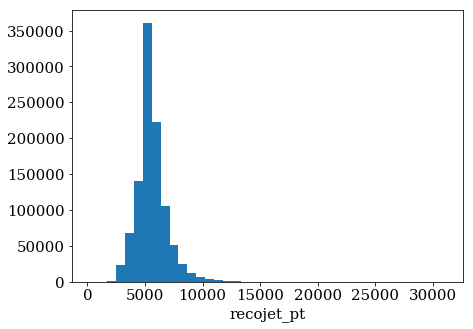

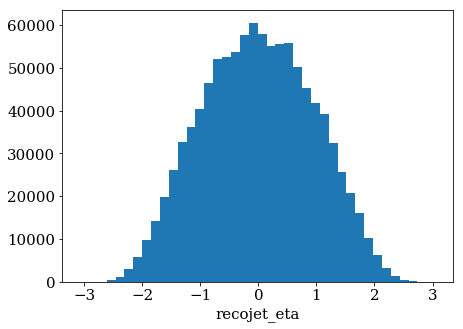

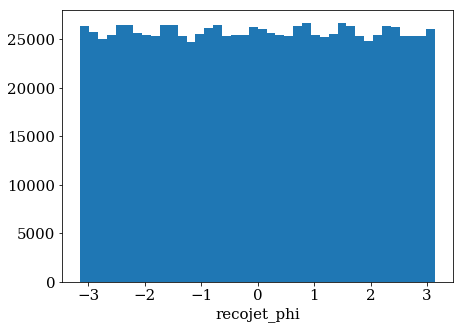

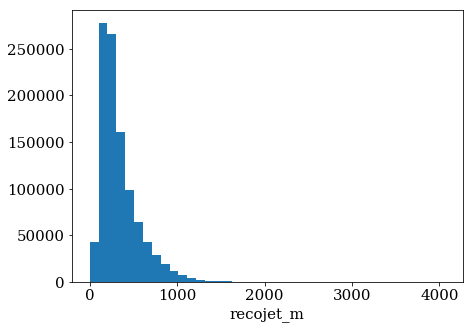

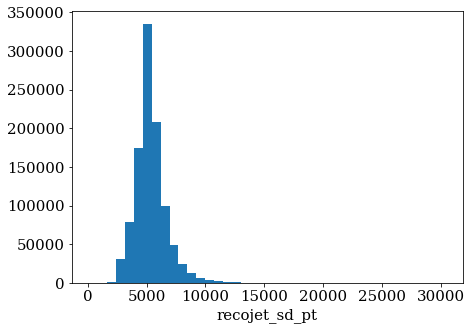

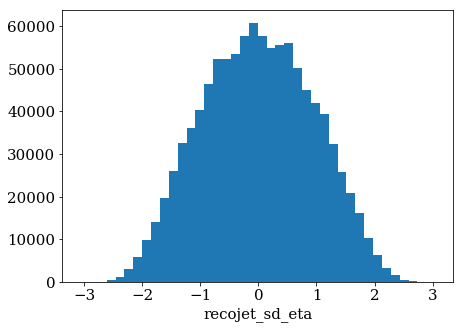

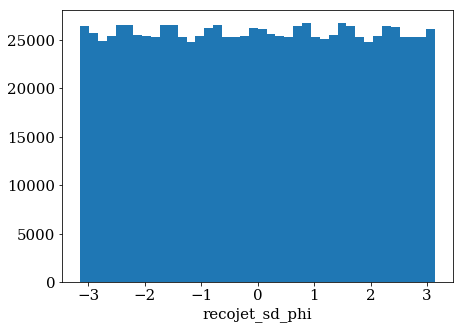

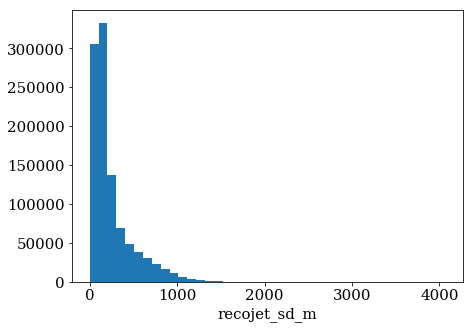

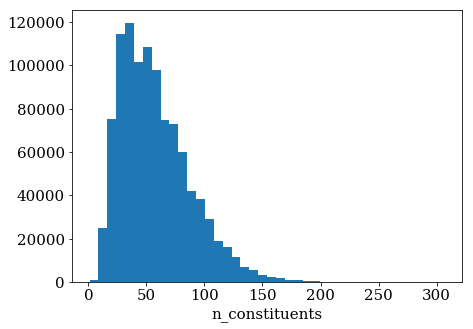

In [3]:
qcd_test = np.load("/bigdata/shared/IML/qcd_test.npy",encoding='bytes')
for key in qcd_test.dtype.names:
    if 'constituents_' not in key:
        if not np.isfinite(qcd_test[key]).all():
            print ("{} has non-numerical values".format(key))
        plt.figure()
        plt.hist(qcd_test[key],bins=40)
        plt.xlabel(key)